# Import packages

In [1]:
from IPython import display

import glob
import imageio
import PIL

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from keras.utils.vis_utils import plot_model
import time

from task_3 import *

%reload_ext autoreload 
%autoreload 2 

# Loading and preprocessing the dataset

In [2]:
# we don't need the labels for VAE, so we just ignore them 
# (for latent space visualization it is nice to have them for visualization but for the training we don't directly need them)
# Split into training (60000 samples) and test (10000 samples) sets
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print("Training set samples shape:", train_images.shape)
print("Test set samples shape:", test_images.shape)
print("Samples have dimension:", len(train_images[0]) * len(train_images[0][0]))

Training set samples shape: (60000, 28, 28)
Test set samples shape: (10000, 28, 28)
Samples have dimension: 784


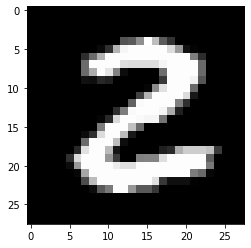

In [3]:
# Let's visualize one of the images to get a feeling of the data that we are handling!
plt.imshow(train_images[25], cmap="gray")
plt.imsave("train_images_25_original.png", train_images[25], cmap="gray")

In [4]:
print("Pixel values type:", type(train_images[0][0][0]))

Pixel values type: <class 'numpy.uint8'>


**Note**: Images have the dimension 28 by 28 with one color channel. Pixel values have the type uint8. We need to convert them to float32 and normalize them between 0 and 1. We also reshape the array to have a single channel. 

Maximum pixel value in the training set is 1.0
Minimum pixel value in the training set is 0.0


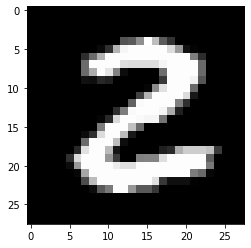

In [5]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
print("Maximum pixel value in the training set is", np.max(train_images))
print("Minimum pixel value in the training set is", np.min(train_images))

# visualization after normalization should look the same
plt.imshow(train_images[25], cmap="gray")

# Shuffle and batch the data

In [6]:
train_size = 60000
test_size = 10000
# 128 batch size is given in the exercise sheet
batch_size = 128

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)>


2022-06-21 18:53:42.459441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 18:53:42.477314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gergedan/.local/repos/ulfm2/4.1.0u1a1-gcc10/lib
2022-06-21 18:53:42.477330: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-21 18:53:42.477934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

# Define the Optimizer

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-3) # learning rate given as 0.001 in the exercise sheet

# number of epochs to do in total in the training
epochs = 500

# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2

# Train and plot the latent representations, reconstructions, generations (decode samples from the prior) for each batch iteration

In [8]:
# example reconstructions to generate during the training after each epoch 
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement
#random_vector_for_generation = tf.random.normal(
#    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [9]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :]

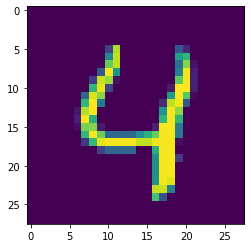

In [10]:
# get the dictionary containing images split in accordance to their labels
mnist_test_dict = split_mnist(test_images, test_labels)

# example for a handwritten 4
plt.imshow(mnist_test_dict["4"][0])

## Initially plot and save the laten space representation 

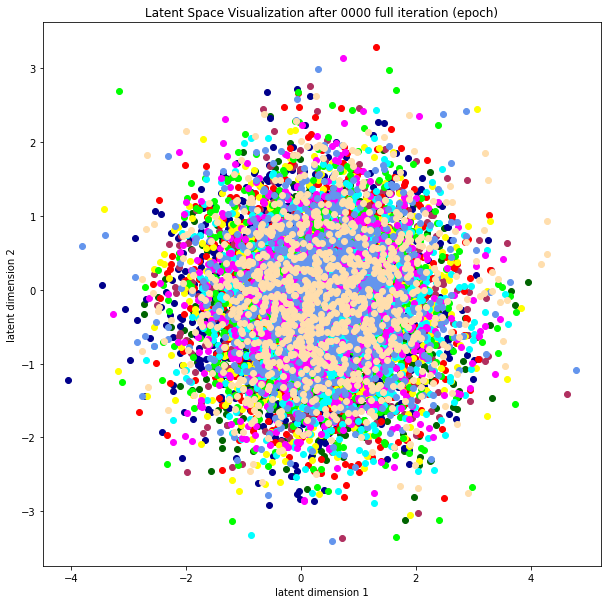

In [11]:
# plot and save latent representation
compute_plot_and_save_latent_representations(model, 0, test_images, test_labels)

As one can see, latent space looks like the assumed prior, standard multivariate diagonal Gaussian. 

## Initially plot and save the reconstructions of 16 images from the test data set

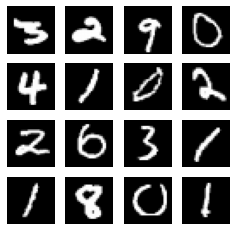

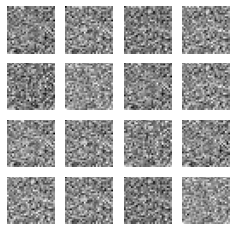

In [12]:
# we first plot the original images so we can compare them with their reconstructions
fig = plt.figure(figsize=(4, 4))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_sample[i, :, :], cmap='gray')
    plt.axis('off')

# tight_layout minimizes the overlap between 2 sub-plots
plt.savefig('original_images_test.png')
plt.show()

# predict the sample images from the test set with initial weights
reconstruct_and_save_images(model, 0, test_sample)

As one can see, the untrained model produces white-noise when trying to reconstruct the images from the test dataset given above.

## Initially plot and save the generations of 16 images (decoded from the prior)

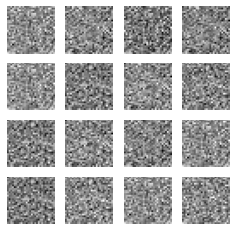

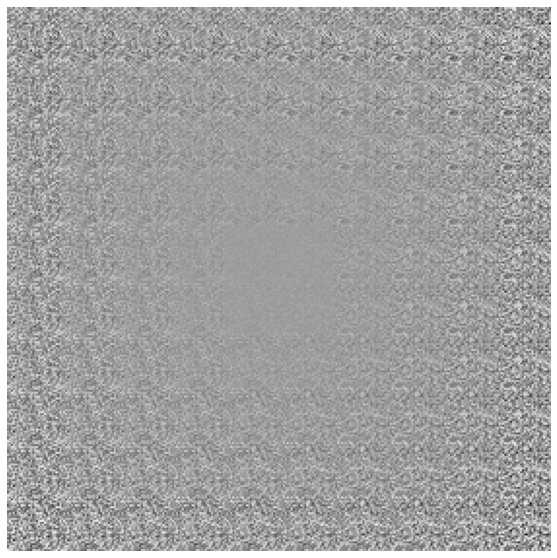

In [13]:
num_images_to_generate = 16

# Generate random images (16 images)
generate_and_save_images(model, 0, 16, latent_dim)

# Now for comparison, we will sample from the same z latent spaces (linearly spaced)
# we will produce 100 images (this should not be called with more than 2 laten dimensions
# since we sample for each latent dimensions and compute the combination ==> exponential overhead scaling!)
if latent_dim == 2:
    plot_latent_images(model, 0, 10)

As one can see, the randomly generated samples as well as the latent space looks like a white-noise on the untrained model. Now we train it and see how these improve over time (number of epochs).

# Training the model (we also train with 32 latent_dim here and save the figures for later comparison)

**Note:** we do not visualize the 32-latent space model (its reconstructions etc.) but we 

Epoch: 500, Test set ELBO: -41.09309387207031, time elapse for current epoch: 1.7750930786132812
Latent Space Representation of the Test Dataset
Reconstruction of the 16 Test Samples


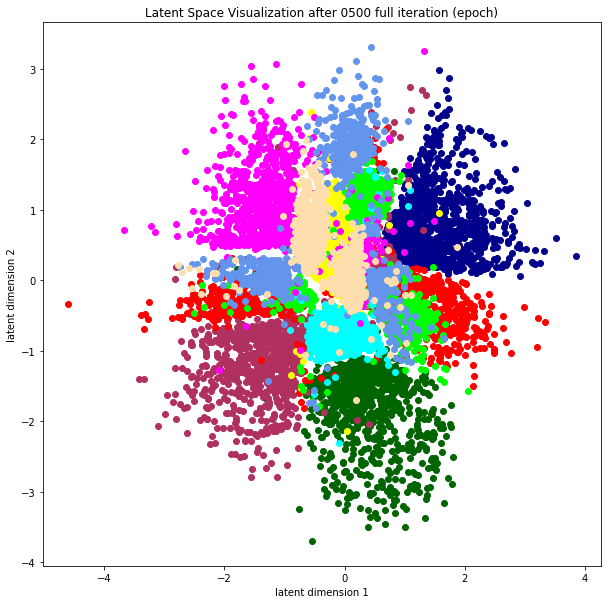

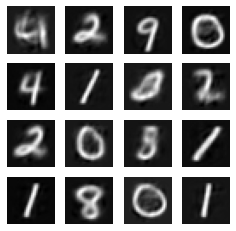

Generation of 16 Images


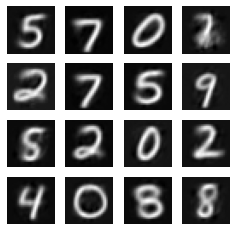

Generation of Images from Evenly Spaced Latent Dimensions


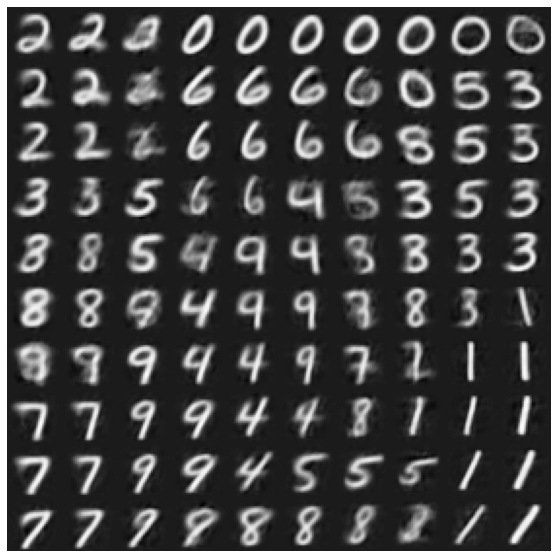

In [14]:
# keep track of the history manually
history_dict = {}
history_dict["train_loss"] = []
history_dict["test_loss"] = []

# Start of the main training loop
for epoch in range(1, epochs + 1):
    # for calcualting the mean loss of the batches 
    train_loss = tf.keras.metrics.Mean()
    
    # time analysis for the current epoch
    start_time = time.time()
    # iterate each batch
    for train_x in train_dataset:
        # do a single training step
        batch_train_loss = train_step(model, train_x, optimizer)
        # save the loss of this batch
        train_loss(batch_train_loss)
    end_time = time.time()
    
    # get the mean loss of the batches
    train_loss_mean = train_loss.result()
    
    # save this mean loss manually to later plot the loss curve
    history_dict["train_loss"].append(train_loss_mean)
    
    # this loss is for the test loss
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        # compute and save the loss for each test batch
        loss(compute_loss(model, test_x))
    
    # get the mean loss of the test batches
    test_loss_mean = loss.result()
    elbo = -test_loss_mean
    
    # save this mean loss again manually to later plot the loss curve for the test loss
    history_dict["test_loss"].append(test_loss_mean)
    
    # clear the current notebook output for nice visualization
    display.clear_output(wait=False)
    
    # print the current epoch and current elbo for the test set
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    
    print("Latent Space Representation of the Test Dataset")
    # plot and save latent representation of the whole test dataset
    compute_plot_and_save_latent_representations(model, epoch, test_images, test_labels)
    
    print("Reconstruction of the 16 Test Samples")
    # plot and save reconstructions of the same images
    reconstruct_and_save_images(model, epoch, test_sample)
    
    print("Generation of 16 Images")
    # Generate random images (16 images)
    generate_and_save_images(model, epoch, 16, latent_dim)

    # Now for comparison, we will sample from the same z latent spaces (linearly spaced)
    # we will produce 100 images (this should not be called with more than 2 laten dimensions
    # since we sample for each latent dimensions and compute the combination ==> exponential overhead scaling!)
    if latent_dim == 2:
        print("Generation of Images from Evenly Spaced Latent Dimensions")
        plot_latent_images(model, epoch, 10)

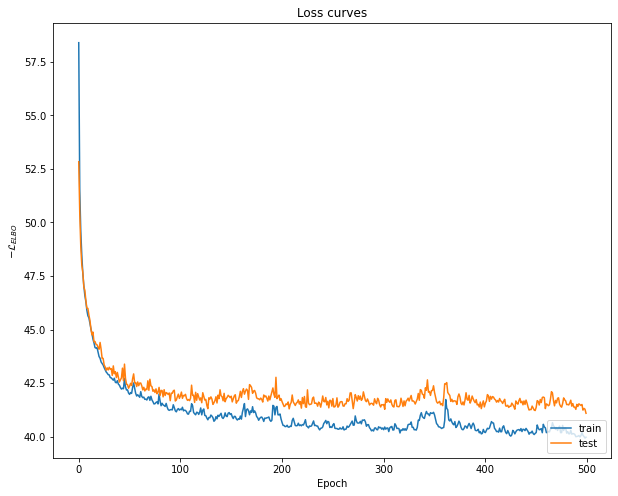

<Figure size 720x576 with 0 Axes>

In [15]:
# Plot the train-test loss 
plot_and_save_loss_curves(history_dict, epoch)

## What activation functions should be used for the mean and standard deviation of the approximate posterior and the likelihood—and why?

Identity since the targets are floating point numbers. 

## What might be the reason if we obtain good reconstructed but bad generated digits?

No (or little) regularization is used, so the KL-divergence between the encoder and the prior is not taken into account while training the network. As a result the reconstruction loss may have converged all the distributions into single points.  

## Train the VAE using a 32-dimensional latent space

**NOTE:** We do the same things as above now for the 32 dimensional latent space. We do not repeat the steps for the 32-dimensional latent space since one can restart the notebook and set the 'latent_dim' variable accordingly to get the model with k-dimensional latent space (K << D). But if the latent space has more than 3 dimensions it would be hard to try to visualize them as we did using the latent space visualization in 2D. However we have included the genenrated samples and reconstructions of the 32-dimensional model in the report and discuss the difference with the 2-dimensional one.